# TODO:

Try:

* Different models:
  * Sarsa Linear (done)
  * Sarsa ANN (done)
  * Q-learning Linear?
  * Q-learning ANN without experience replay
  * Q-learning ANN with experience replay
  * Q-learning ANN with experience replay and policy/target network split?
* Different loss functions:
  * MSE -> leads to updates as in Sutton, Barto
  * SmoothL1?
  * What do they use in DQN paper?

In [1]:
import sys
sys.path.append("..")
from rl_utils import *
from cart_pole import *

# Settings

In [23]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_EPISODES = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", device)

PyTorch device: cuda


# Sarsa

## Linear model

Average return per episode: 20.229


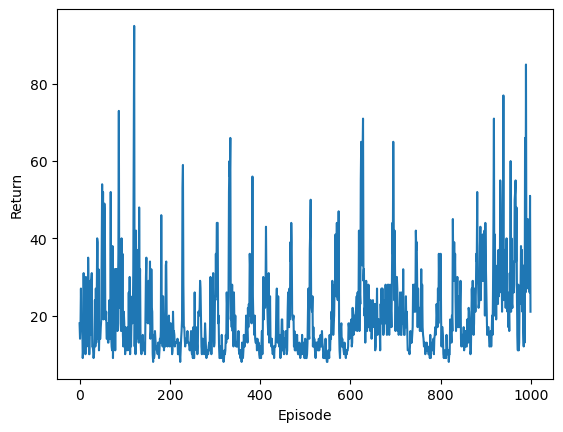

In [24]:
env = gym.make(ENVIRONMENT_ID)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_sarsa(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

## Simple Neural Network

Average return per episode: 64.57


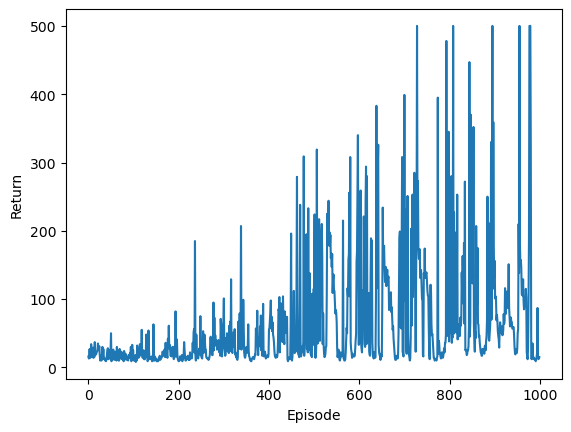

In [4]:
env = gym.make(ENVIRONMENT_ID)
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_sarsa(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

# Q-learning

## Linear model

Average return per episode: 20.426


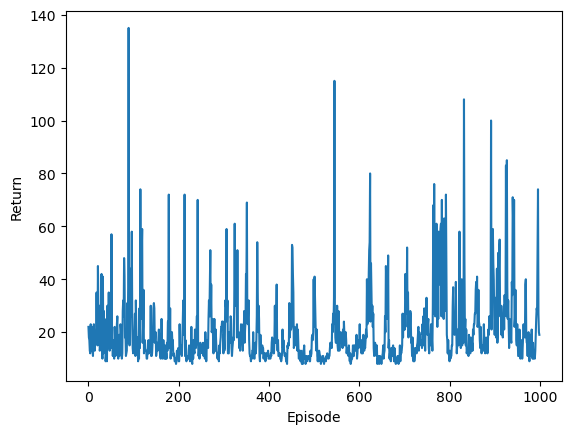

In [5]:
env = gym.make(ENVIRONMENT_ID)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_qlearning(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

## Simple Neural Network

In [22]:
env = gym.make(ENVIRONMENT_ID)
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_qlearning(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

NameError: name 'ENVIRONMENT_ID' is not defined

# Q-learning with experience replay

## Linear Model

In [ ]:
def train_episodic_semi_gradient_qlearning_experience_replay(env, model, loss_func, optimizer, device, num_episodes, memory_len):
    eps = 1
    returns = []
    memory = deque(maxlen=memory_len)
    for ep in range(num_episodes):
        observation, info = env.reset()
        state = torch.tensor(observation, device=device)
        truncated = False
        terminated = False
        G = 0

        while not (terminated or truncated):
            action = select_action_eps_greedy(env, model, state, eps)
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = torch.tensor(observation, device=device)
            G += reward

            if terminated:
                memory.append((state, action, reward, None))
            else:
                state = next_state

        eps = update_eps(eps)
        returns.append(G)
    return returns

In [98]:
replay_memory = ReplayMemory(2)
replay_memory.store((0, 0, 0, 0), 0, 0, (1, 1, 1, 1))
replay_memory.store((2, 2, 2, 2), 0, 0, (3, 3, 3, 3))
state_batch, action_batch, reward_batch, next_state_batch = replay_memory.retrieve_sample_batch(2)
print("state_batch")
print(state_batch)
print(state_batch.shape)
print("action_batch")
print(action_batch)
print("reward_batch")
print(reward_batch)
print("next_state_batch")
print(next_state_batch)

state_batch
[[0 0 0 0]
 [2 2 2 2]]
(2, 4)
action_batch
[0 0]
reward_batch
[0 0]
next_state_batch
[[1 1 1 1]
 [3 3 3 3]]


In [99]:
state_batch = torch.tensor(state_batch, dtype=torch.float32, device=device)

In [100]:
for p in model.parameters():
    print(p.dtype)

torch.float32
torch.float32


In [101]:
model(state_batch)

tensor([[26.7204, 26.3823],
        [56.5651, 31.4639]], device='cuda:0', grad_fn=<AddmmBackward0>)